# Get the names and indexes of the response genes.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

import os
import torch

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.models.monet_ae import MonetDense
from spatial.predict import test

import hydra
from hydra.experimental import compose, initialize

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [2]:
response_genes=np.array(['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2'])

In [3]:
data = pd.read_csv("../data/raw/merfish.csv")

In [4]:
data = data.drop(["Fos", "Blank_1", "Blank_2", "Blank_3", "Blank_4", "Blank_5"], axis=1)

In [5]:
data = data.iloc[:, 9:]

In [6]:
data.shape, data.columns # should start with "Ace2"

((1027848, 155),
 Index(['Ace2', 'Adora2a', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar',
        'Arhgap36', 'Avpr1a', 'Avpr2',
        ...
        'Penk', 'Scg2', 'Sln', 'Sst', 'Tac1', 'Tac2', 'Th', 'Trh', 'Ucn3',
        'Vgf'],
       dtype='object', length=155))

In [7]:
response_indexes = [0,2,3,4,5,6,7,10,19,20,21,22,23,24,25,26,27,28,32,34,35,37,38,39,40,41,42,43,44,52,53,54,55,58,63,64,66,67,69,71,73,74,75,76,77,78,79,80,85,86,87,88,93,94,96,97,99,102,103,104,106,110,112,113,114,116,118,119,120,121,122,123,124,125,126,129,130,131,133,134,141,142,147,151]

In [8]:
IGNORANT_RADIUS = 0
AWARE_RADIUS = [5,10,15,20,25,30,35,40,45,50]

# Load the test losses for spatially ignorant baseline.

In [9]:
test_loss_rad_dict = {}

for rad in [IGNORANT_RADIUS]:
    with initialize(config_path="../config"):
        # try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
            OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 71)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", 15)
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "table2_FULL_no_celltypes")
            OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
            test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        # except:
        #     try:
        #         OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
        #         print(cfg_from_terminal.training.filepath)
        #         output = test(cfg_from_terminal)
        #         trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
        #         test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        #     except:
        #         print(f"Model with radius of {rad} micrometers doesn't exist :(")

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


MonetDense__[512, 512, 512, 512, 512, 512]__0__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.33it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__table2_FULL_no_celltypes__Adam.ckpt`
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


The number of parameters for radius 0 is 23641248


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: |          | 0/? [00:00<?, ?it/s]

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5700. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6019. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5667. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/py

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.34988829493522644    │
│       test_loss_mse       │    0.34988829493522644    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

# Load the test losses for spatially aware model.

In [10]:
def calc_r2(truth, predictions):
    SS_res = torch.sum((truth - predictions)**2).item()
    SS_tot = torch.sum((truth - torch.mean(truth))**2).item()
    return 1 - SS_res/SS_tot

In [11]:
with open("0v60.json", "r") as f:
    loss_dict = json.load(f)

In [12]:
r2_dict = {}
inputs_BASE_responses = inputs_BASE[:, response_indexes]

for rad in AWARE_RADIUS:
    with initialize(config_path="../config"):
        try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
            OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 71)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", 15)
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "table2_FULL_no_celltypes")
            OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
            test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
        except:
            try:
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
                print(cfg_from_terminal.training.filepath)
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
            except:
                print(f"Model with radius of {rad} micrometers doesn't exist :(")
    loss_dict[rad] = {}
    r2_dict[rad] = {}
    for i, gene in enumerate(response_genes):
        inputs_SPATIAL_responses = inputs_SPATIAL[:, response_indexes]
        current_gene = data.columns[response_indexes[i]]
        r2_dict[rad][current_gene] = {"base": calc_r2(inputs_BASE_responses[:, i], gene_expressions_BASE[:, i]), "spatial": calc_r2(inputs_SPATIAL_responses[:, i], gene_expressions_SPATIAL[:, i])}
        loss_dict[rad][current_gene] = {"base": torch.mean( (inputs_BASE_responses[:, i] - gene_expressions_BASE[:, i]) ** 2 ).item(), "spatial": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_SPATIAL[:, i]) ** 2 ).item()}
        loss_dict[rad][current_gene]["diff"] = loss_dict[rad][current_gene]["spatial"] - loss_dict[rad][current_gene]["base"]
        loss_dict[rad][current_gene]["percent_diff"] = (loss_dict[rad][current_gene]["diff"]/loss_dict[rad][current_gene]["base"]) * 100.0

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(


MonetDense__[512, 512, 512, 512, 512, 512]__5__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.28it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__5__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 5 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3494284152984619     │
│       test_loss_mse       │    0.3494284152984619     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__10__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.32it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__10__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 10 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3461569845676422     │
│       test_loss_mse       │    0.3461569845676422     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__15__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:17<00:00,  1.33it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__15__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 15 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33938685059547424    │
│       test_loss_mse       │    0.33938685059547424    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__20__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.32it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__20__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 20 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3366208076477051     │
│       test_loss_mse       │    0.3366208076477051     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__25__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.32it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 25 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33311593532562256    │
│       test_loss_mse       │    0.33311593532562256    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__30__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 30 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.338060200214386     │
│       test_loss_mse       │     0.338060200214386     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__35__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.29it/s]
Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__35__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 35 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3344235420227051     │
│       test_loss_mse       │    0.3344235420227051     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__40__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.32it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 40 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3356146514415741     │
│       test_loss_mse       │    0.3356146514415741     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__45__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.31it/s]
Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__45__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 45 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33421823382377625    │
│       test_loss_mse       │    0.33421823382377625    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

MonetDense__[512, 512, 512, 512, 512, 512]__50__table2_FULL_no_celltypes__Adam


100%|██████████| 24/24 [00:18<00:00,  1.31it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 50 is 23641248


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33544057607650757    │
│       test_loss_mse       │    0.33544057607650757    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  366            	

# Get the losses for each response gene in both cases.

In [13]:
# loss_dict

In [14]:
with open("0v60.json", "w") as file:
    json.dump(loss_dict, file)

In [15]:
# r2_dict

In [16]:
with open("r2_0v60.json", "w") as file:
    json.dump(r2_dict, file)

# Plot the results.

In [17]:
import matplotlib.pyplot as plt

In [18]:
loss_dict = loss_dict['25']

In [19]:
percent_differences = [-loss_dict[x]["percent_diff"] for x in loss_dict]

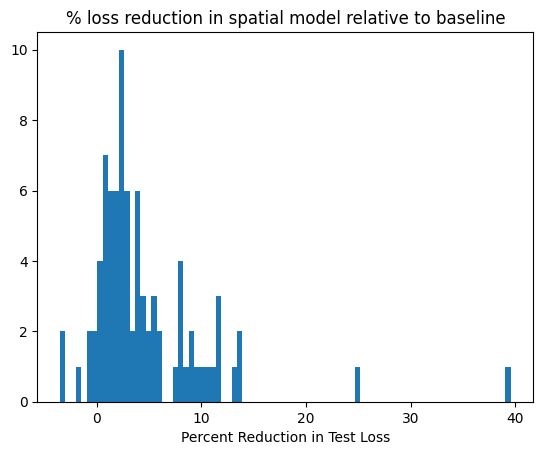

In [20]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% loss reduction in spatial model relative to baseline")
plt.xlabel("Percent Reduction in Test Loss")
plt.show()

# Identify the genes.

In [21]:
loss_dict_sorted = dict(sorted(loss_dict.items(), key=lambda item: item[1]["percent_diff"]))

In [22]:
loss_dict_sorted

{'Nnat': {'base': 0.01004598755389452,
  'spatial': 0.006069127004593611,
  'diff': -0.003976860549300909,
  'percent_diff': -39.586556602483576},
 'Mbp': {'base': 0.05439237877726555,
  'spatial': 0.04089765623211861,
  'diff': -0.013494722545146942,
  'percent_diff': -24.809951041867926},
 'Ebf3': {'base': 0.16109047830104828,
  'spatial': 0.13900195062160492,
  'diff': -0.02208852767944336,
  'percent_diff': -13.711876649943264},
 'Sln': {'base': 0.05354680120944977,
  'spatial': 0.04632866755127907,
  'diff': -0.0072181336581707,
  'percent_diff': -13.48004641759416},
 'Ermn': {'base': 0.7739373445510864,
  'spatial': 0.6704298853874207,
  'diff': -0.10350745916366577,
  'percent_diff': -13.374139378647518},
 'Cd24a': {'base': 0.49862006306648254,
  'spatial': 0.44017210602760315,
  'diff': -0.058447957038879395,
  'percent_diff': -11.721942490526368},
 'Greb1': {'base': 0.2096237987279892,
  'spatial': 0.18519610166549683,
  'diff': -0.02442769706249237,
  'percent_diff': -11.6531

# Annotated Plot

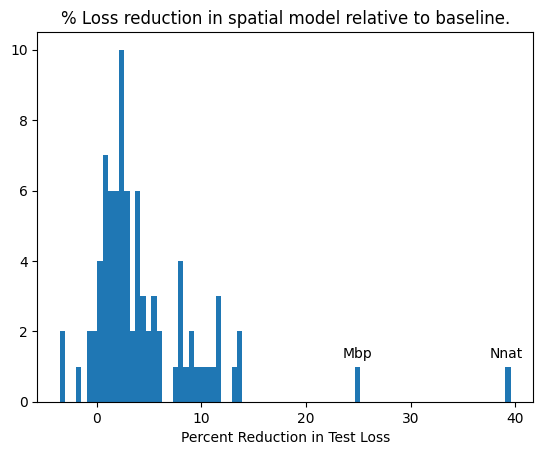

In [23]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% Loss reduction in spatial model relative to baseline.")
plt.xlabel("Percent Reduction in Test Loss")
plt.annotate("Nnat", xy=(39.5866-2, 1.25))
plt.annotate("Mbp", xy=(24.8099-1.3, 1.25))
plt.savefig("0VSspatial.png", dpi=300)
plt.show()

# Heatmap

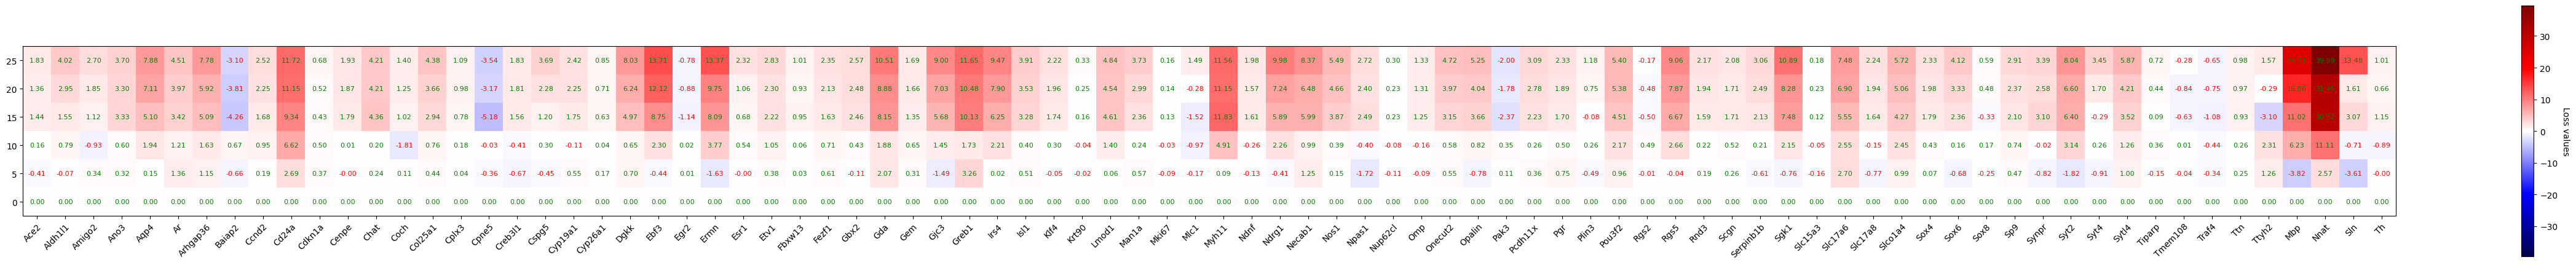

In [24]:
import numpy as np
import matplotlib.pyplot as plt

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(25, -1, -5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
]).T

# Set the figure size based on the dimensions of your data
cell_width = 0.5
cell_height = 2.5
fig, ax = plt.subplots(figsize=(cell_width*len(genes), cell_height*len(radius_values)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.005)
cbar.ax.set_ylabel("Loss values", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(genes)))
ax.set_xticklabels(genes)
ax.set_yticks(np.arange(len(radius_values)))
ax.set_yticklabels(list(radius_values))


# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(radius_values)):
    for j in range(len(genes)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=8)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
fig.tight_layout()
plt.savefig("spatial_horizontal.png", dpi=600)
plt.show()

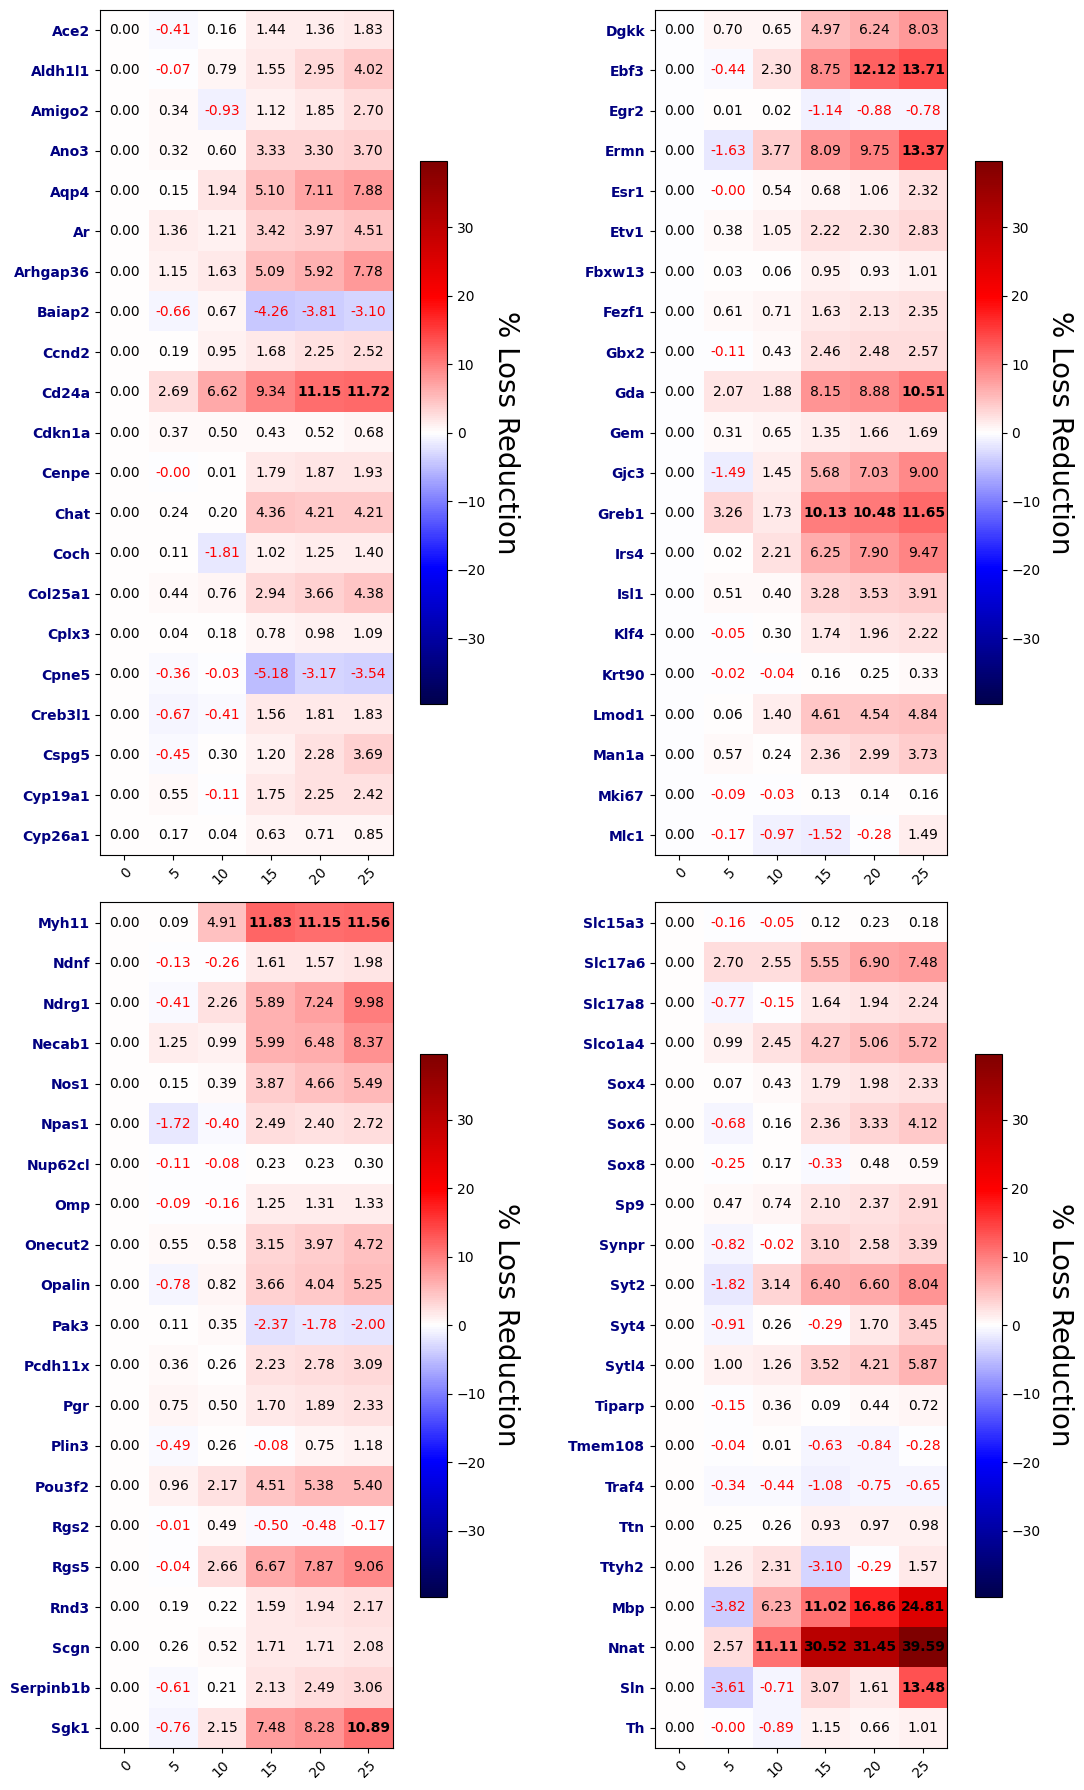

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import json

plt.style.use('default')

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

# (Assuming these variables are defined elsewhere in your code)
# radius_values, genes, data, response_indexes

fig, axes = plt.subplots(2, 2, figsize=(12,18))

quarter = 0

full_loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 
     for rad in radius_values] 
    for gene in genes
]).T

for ax in axes.ravel():
    
    quarter += 1
    radius_values = list(range(0, 26, 5))
    n = len(response_indexes)
    genes = [data.columns[response_indexes[i]] 
             for i in range(n * (quarter - 1) // 4, n * quarter // 4)]
    
    loss_array = np.array([
        [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 
         for rad in radius_values] 
        for gene in genes
    ])
    
    im = ax.imshow(loss_array, cmap='seismic', 
                   vmin=-np.max(np.abs(full_loss_array)), 
                   vmax=np.max(np.abs(full_loss_array)))
    
    # Increase the width of each cell by adjusting the aspect ratio.
    # A value less than 1 (e.g. 0.825) makes cells wider horizontally.
    ax.set_aspect(0.825)
    
    # Add a colorbar with an adjusted fraction to make it thinner.
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
    cbar.ax.set_ylabel("% Loss Reduction", fontsize=20, rotation=-90, va="bottom")
    
    ax.set_xticks(np.arange(len(radius_values)))
    ax.set_xticklabels(list(radius_values))
    
    # Here we set the gene names (y-axis labels) with a custom font dict.
    gene_font = {'fontsize': 10, 'fontweight': 'bold', 'color': 'navy'}
    ax.set_yticks(np.arange(len(genes)))
    ax.set_yticklabels(genes, fontdict=gene_font)
    
    # Adjust tick font sizes for both axes
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Dynamically adjust text color and font weight based on cell value
    for i in range(len(genes)):
        for j in range(len(radius_values)):
            text_color = 'red' if loss_array[i, j] < 0 else 'black'
            # Make text bold if the loss is greater than 10 (adjust the condition as needed)
            fontweight = 'bold' if loss_array[i, j] > 10 else 'normal'
            ax.text(j, i, f"{loss_array[i, j]:.2f}",
                    ha="center", va="center", color=text_color,
                    fontsize=10, fontweight=fontweight)

fig.tight_layout()
plt.savefig("spatial_vertical_full.png", dpi=600)
plt.show()

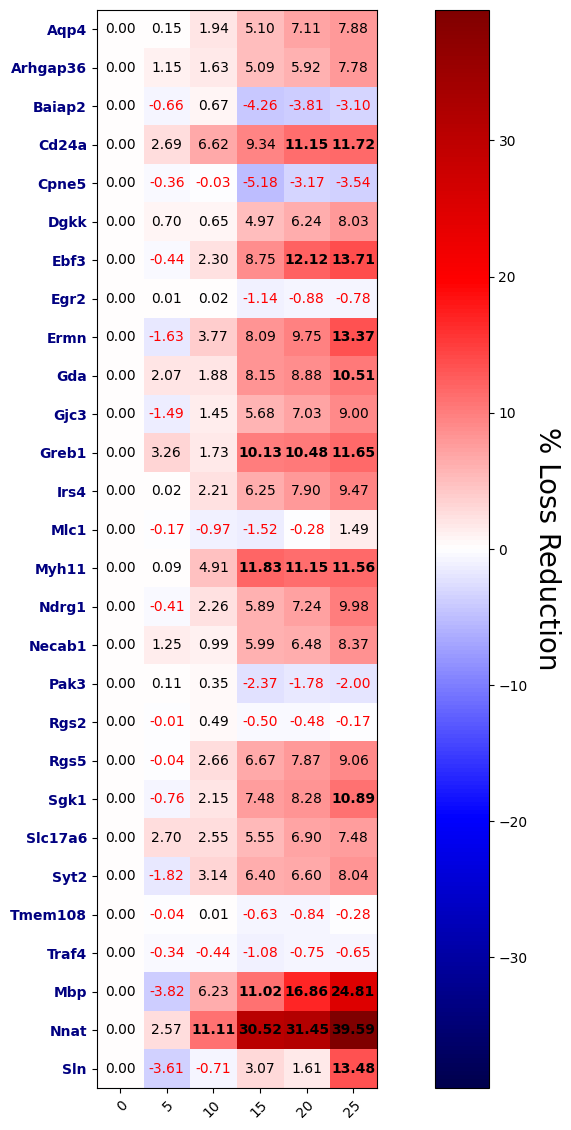

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
THRESHOLD_ABS = 20
THRESHOLD_MIN = 0
genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Increase the width of each cell by adjusting the aspect ratio.
# A value less than 1 (e.g. 0.825) makes cells wider horizontally.
ax.set_aspect(0.825)

# Add a colorbar with an adjusted fraction to make it thinner.
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel("% Loss Reduction", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))

# Here we set the gene names (y-axis labels) with a custom font dict.
gene_font = {'fontsize': 10, 'fontweight': 'bold', 'color': 'navy'}
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes, fontdict=gene_font)

# Adjust tick font sizes for both axes
ax.tick_params(axis='both', which='major', labelsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color and font weight based on cell value
for i in range(len(genes)):
    for j in range(len(radius_values)):
        text_color = 'red' if loss_array[i, j] < 0 else 'black'
        # Make text bold if the loss is greater than 10 (adjust the condition as needed)
        fontweight = 'bold' if loss_array[i, j] > 10 else 'normal'
        ax.text(j, i, f"{loss_array[i, j]:.2f}",
                ha="center", va="center", color=text_color,
                fontsize=10, fontweight=fontweight)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical.png", dpi=600)
plt.show()

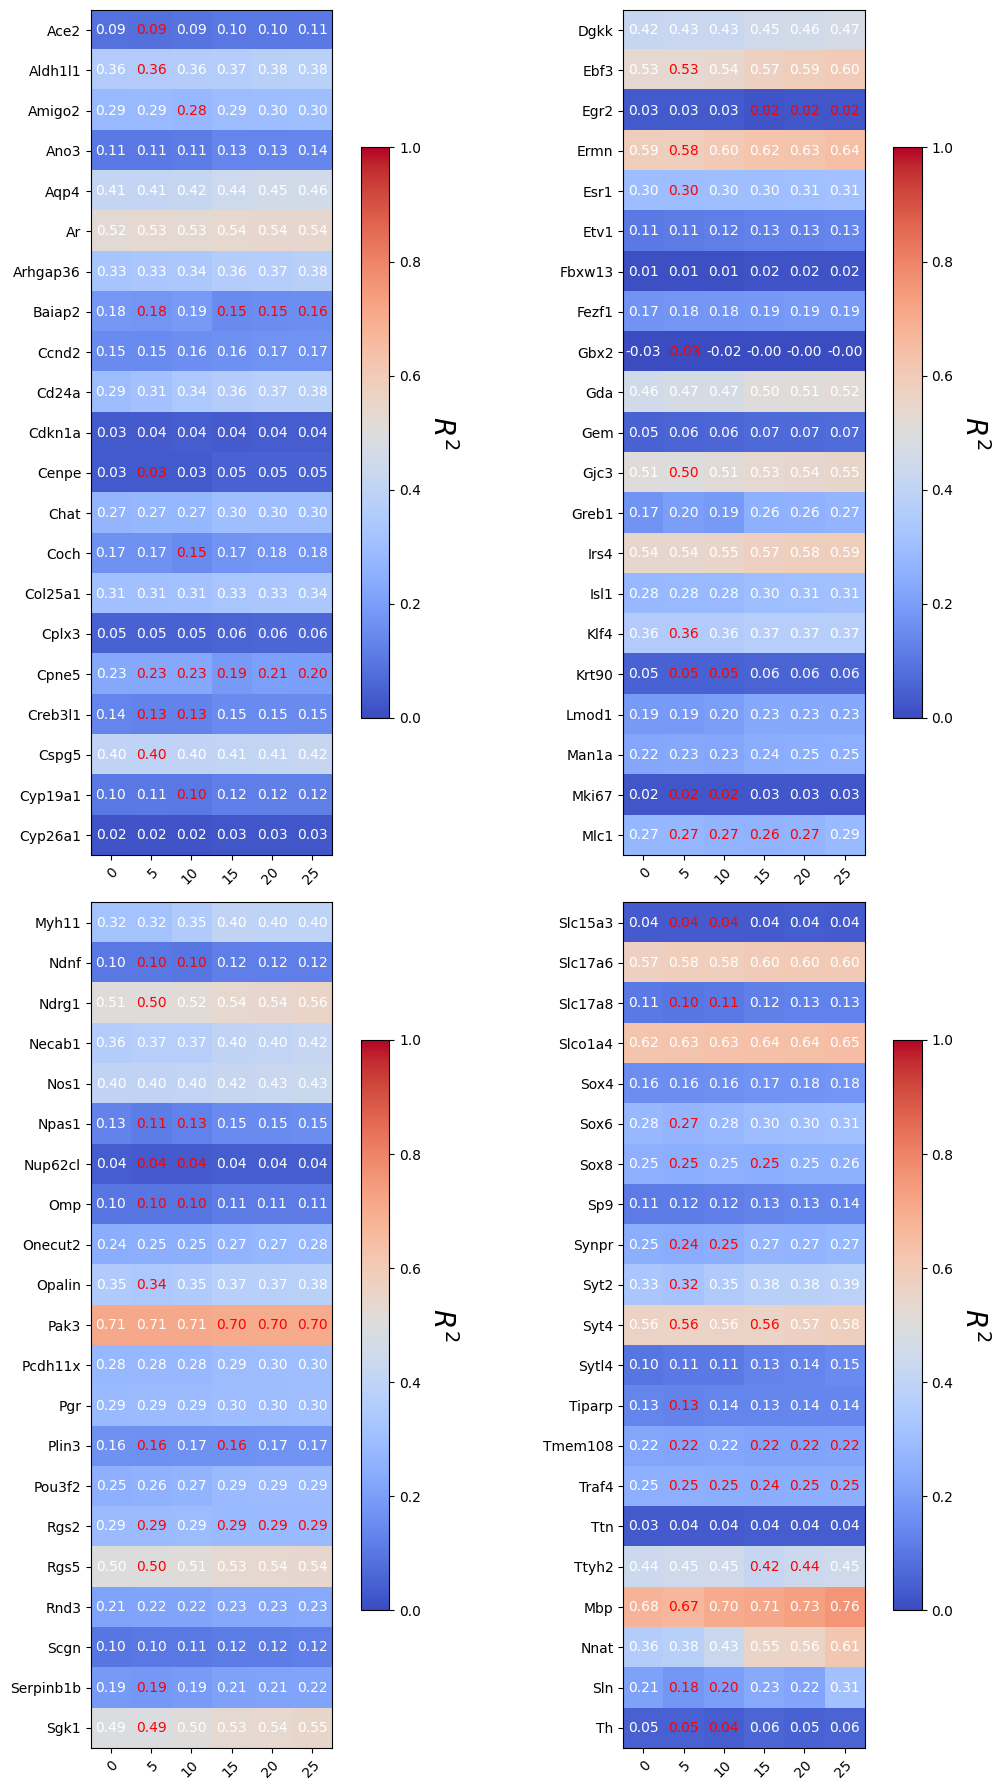

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("r2_0v60.json", "r") as file:
    r2_dict = json.load(file)

fig, axes = plt.subplots(2, 2, figsize=(12,18))

quarter = 0

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

full_r2_array = np.array([
    [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
])

for ax in axes.ravel():
    
    quarter += 1
    n = len(response_indexes)
    genes = [data.columns[response_indexes[i]] for i in range(n * (quarter - 1) // 4, n * quarter // 4)]
    
    r2_array = np.array([
        [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
    ])

    # Set the figure size based on the dimensions of your data
    cell_width = 2.5
    cell_height = 0.5
    
    im = ax.imshow(r2_array, cmap='coolwarm', vmin=0, vmax=1)
    
    # Add a colorbar for reference with adjusted fraction to make it thinner
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
    cbar.ax.set_ylabel(r"$R^2$", fontsize=20, rotation=-90, va="bottom")
    
    ax.set_xticks(np.arange(len(radius_values)))
    ax.set_xticklabels(list(radius_values))
    ax.set_yticks(np.arange(len(genes)))
    ax.set_yticklabels(genes)
    
    # Adjust font size
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Dynamically adjust text color based on cell value and format the number to 2 decimal places
    for i in range(len(genes)):
        for j in range(len(radius_values)):
            if r2_array[i, j] < r2_array[i, 0]:  # If value is negative, use white text
                text_color = 'red'
            else:  # Otherwise, use black text
                text_color = 'white'
            text = ax.text(j, i, f"{r2_array[i, j]:.2f}",
                           ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
fig.tight_layout()
plt.savefig("spatial_vertical_r2.png", dpi=600)
plt.show()

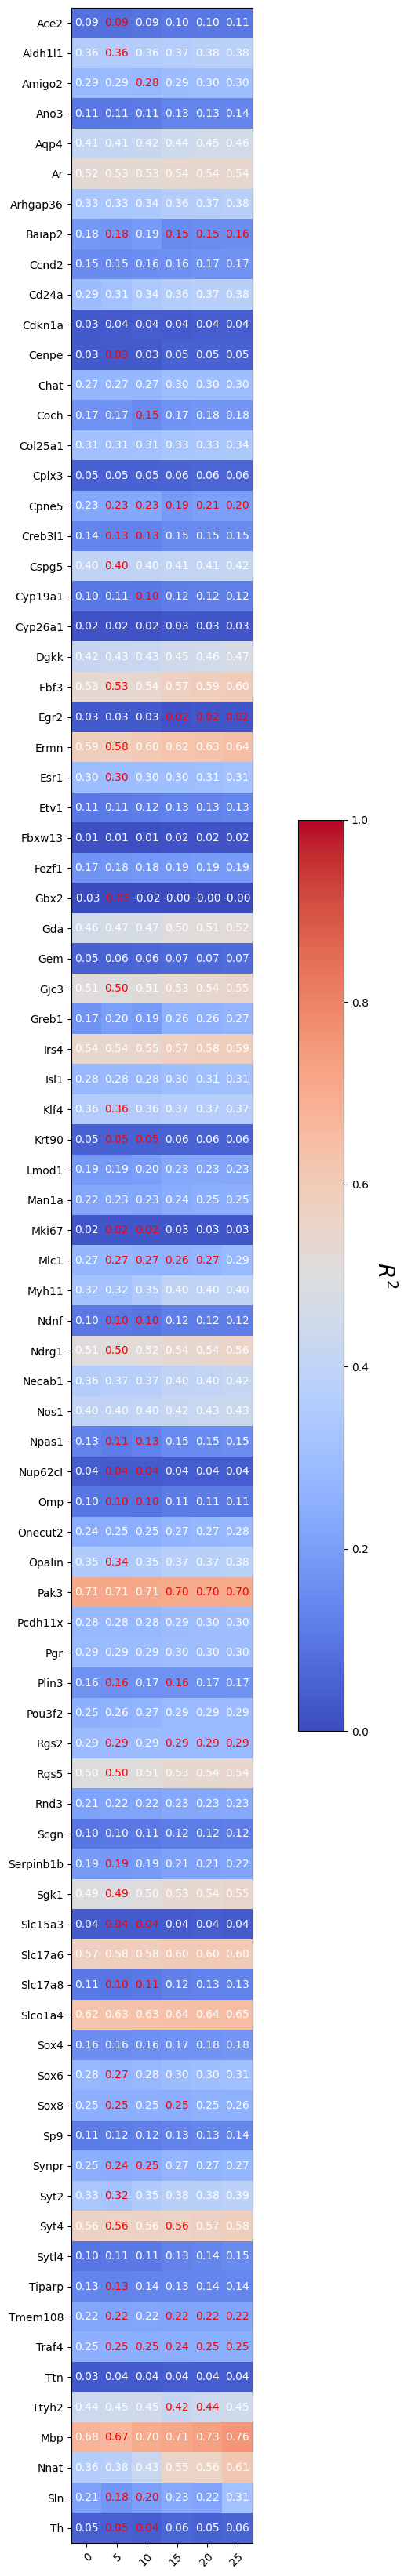

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("r2_0v60.json", "r") as file:
    r2_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

r2_array = np.array([
    [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(r2_array, vmin=0, vmax=1, cmap="coolwarm")
# im = ax.imshow(r2_array, vmin=0, vmax=1, cmap="PiYG")

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel(r"$R^2$", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if r2_array[i, j] < r2_array[i, 0]:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'white'
        text = ax.text(j, i, f"{r2_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_r2.png", dpi=600)
plt.show()

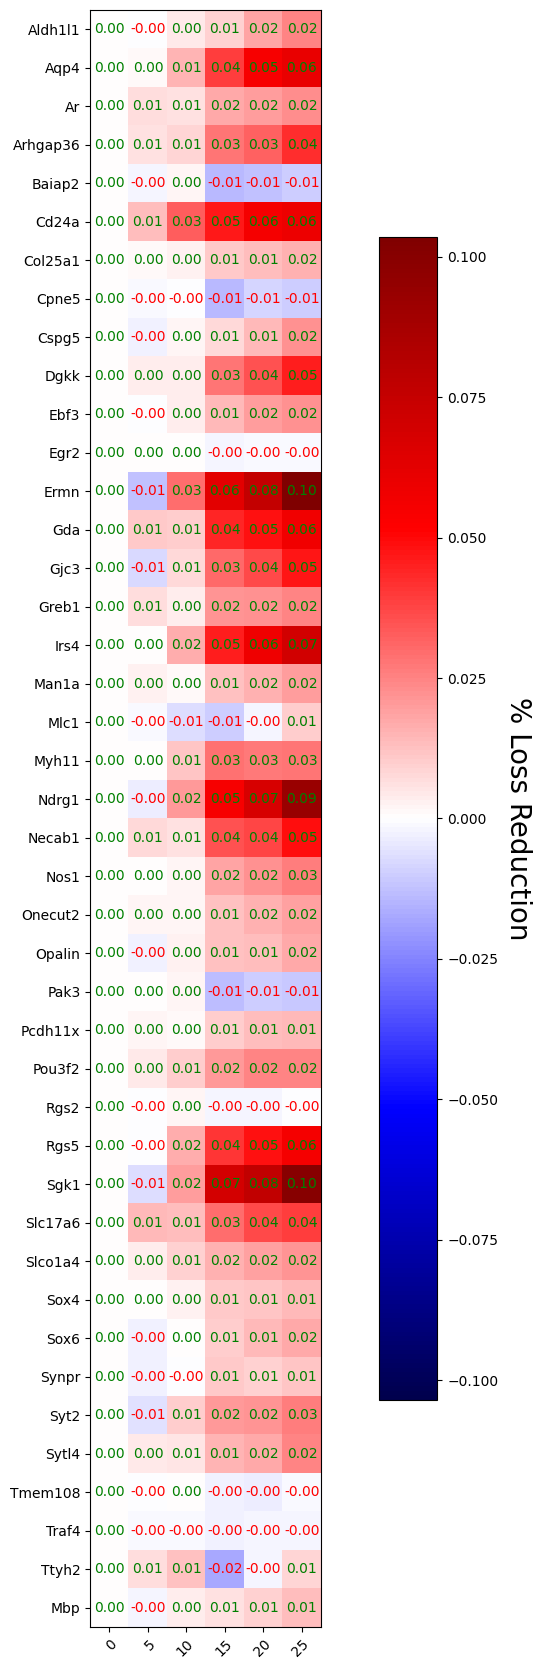

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
THRESHOLD_ABS = 0.03
THRESHOLD_MIN = 0
genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel("% Loss Reduction", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_LRT.png", dpi=600)
plt.show()

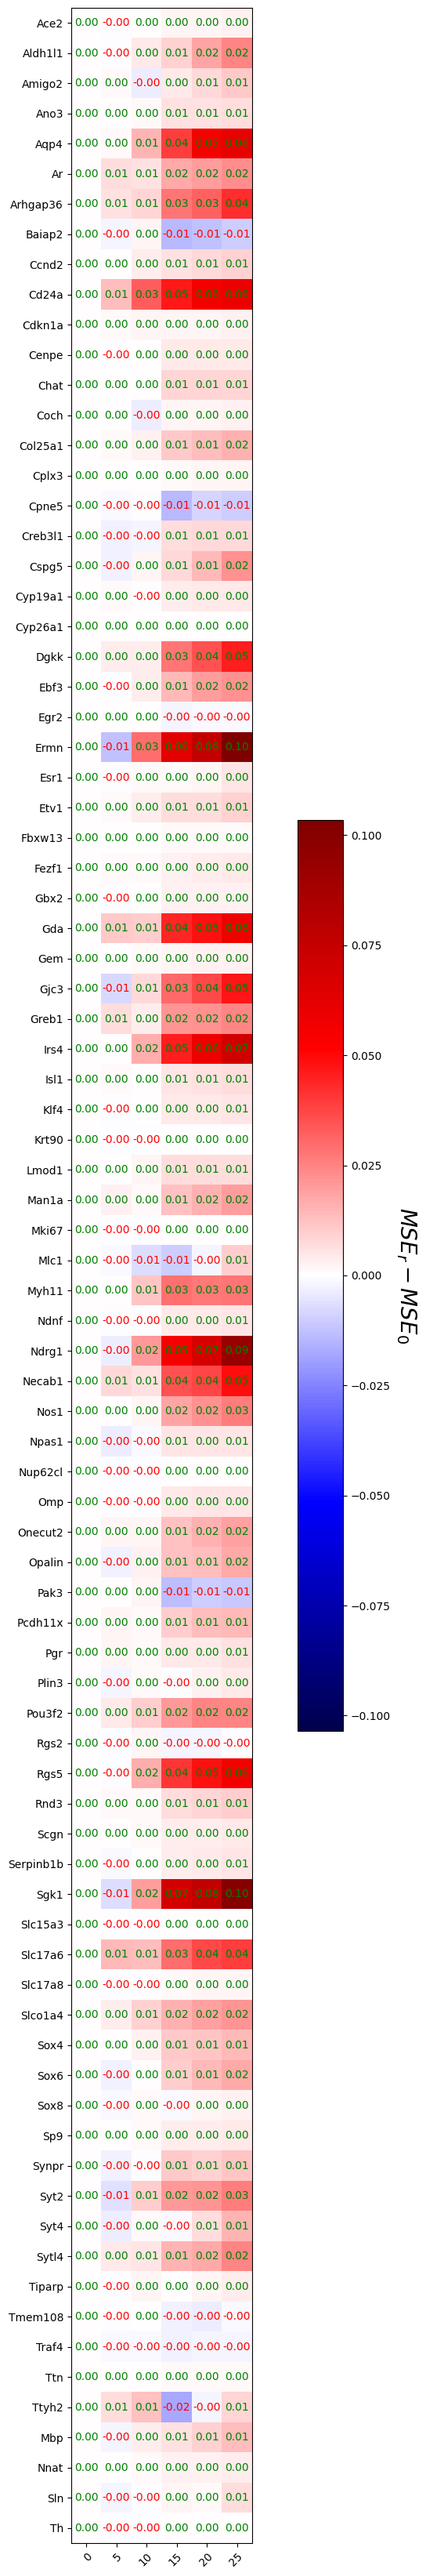

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
# THRESHOLD_ABS = 0.03
# THRESHOLD_MIN = 0
# genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
# loss_array = np.array([
#     [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
# ])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel(r"$MSE_{r} - MSE_{0}$", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_LRT_full.png", dpi=600)
plt.show()

In [59]:
# LRT on real data.
import numpy as np
import scipy.stats as stats
print(len(response_genes), len(response_indexes))

for index, gene in enumerate(genes):
    # get gene index
    gene_index = index
    # get gene sample variance
    sample_var = inputs_BASE_responses[:, gene_index].var(axis=0)
    # Define the mean and standard deviation for the Gaussian distribution
    mean = (1 / 2 * sample_var) * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2
    std_dev = ((1 / sample_var) * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2) ** 0.5
    # Get Rejection Criterion
    value_at_05_cdf = stats.norm.ppf(0.05, loc=mean, scale=std_dev)
    # LRT Stat Calculation
    lrt_stat = (2 * inputs_BASE_responses[:, gene_index] * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) + (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2)/ (2 * sample_var)
    print(gene, (lrt_stat.numpy() < value_at_05_cdf).mean())
    # 

84 84
Ace2 0.08805583665694386
Aldh1l1 0.1712899577355795
Amigo2 0.12622775165188405
Ano3 0.08716292636466456
Aqp4 0.13338591582832313
Ar 0.09993154354425858
Arhgap36 0.1118072504315733
Baiap2 0.1550985177689148
Ccnd2 0.12395827132567415
Cd24a 0.06496666468242157
Cdkn1a 0.11373444847907614
Cenpe 0.1321135186618251
Chat 0.03239776177153402


/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Coch 0.061744746711113754
Col25a1 0.12781266742067982
Cplx3 0.042919221382225134
Cpne5 0.12780522650157747
Creb3l1 0.11613786534912793
Cspg5 0.3436514078218942
Cyp19a1 0.07756414072266206
Cyp26a1 0.024101136972438836
Dgkk 0.13897404607417108
Ebf3 0.03960057146258706
Egr2 0.08967051610214893
Ermn 0.09797458182034645
Esr1 0.07409667242097744
Etv1 0.11226114649681529
Fbxw13 0.11148729091017323
Fezf1 0.0726531341151259
Gbx2 0.10110720876242633
Gda 0.11138311804274063
Gem 0.05273379367819513
Gjc3 0.16384903863325198
Greb1 0.07678284421691767
Irs4 0.13271623310911365
Isl1 0.04455622358473719
Klf4 0.041713792487648074
Krt90 0.048276683135900944
Lmod1 0.06425977736770046
Man1a 0.09392672182868028
Mki67 0.007106077742722781
Mlc1 0.24906244419310672
Myh11 0.035076492648371926
Ndnf 0.09471545925352699
Ndrg1 0.20850199416631943
Necab1 0.06191588785046729
Nos1 0.13017887969521996
Npas1 0.09112893624620513
Nup62cl 0.028610333948449314
Omp 0.10168015953330556
Onecut2 0.09075689029108876
Opalin 0.1127

In [62]:
# LRT on real data.
import numpy as np
import scipy.stats as stats
print(len(response_genes), len(response_indexes))

for index, gene in enumerate(genes):
    # get gene index
    gene_index = index
    # get gene sample variance
    sample_var = inputs_BASE_responses[:, gene_index].var(axis=0)
    # Define the mean and standard deviation for the Gaussian distribution
    mean = (1 / 2 * sample_var) * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2
    std_dev = ((1 / sample_var) * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2) ** 0.5
    # Get Rejection Criterion
    value_at_05_cdf = stats.norm.ppf(0.05, loc=mean.sum(), scale=std_dev.sum())
    # LRT Stat Calculation
    lrt_stat = (2 * inputs_BASE_responses[:, gene_index].sum() * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]).sum() + (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2).sum()/ (2 * sample_var)
    print(gene, (lrt_stat.numpy() < value_at_05_cdf))
    # 

84 84
Ace2 True
Aldh1l1 True
Amigo2 True
Ano3 True
Aqp4 True
Ar False
Arhgap36 True
Baiap2 True
Ccnd2 True
Cd24a False
Cdkn1a True
Cenpe True
Chat False
Coch False
Col25a1 True
Cplx3 False
Cpne5 True
Creb3l1 False
Cspg5 True
Cyp19a1 True
Cyp26a1 False
Dgkk False
Ebf3 True
Egr2 True
Ermn False
Esr1 False
Etv1 True
Fbxw13 True
Fezf1 True
Gbx2 True
Gda False
Gem False
Gjc3 True
Greb1 True
Irs4 False
Isl1 False
Klf4 True
Krt90 False
Lmod1 True
Man1a False
Mki67 False
Mlc1 True
Myh11 False
Ndnf True
Ndrg1 False
Necab1 False
Nos1 True
Npas1 True
Nup62cl False
Omp False
Onecut2 True
Opalin True
Pak3 False
Pcdh11x True
Pgr True
Plin3 True
Pou3f2 True
Rgs2 False
Rgs5 False
Rnd3 False
Scgn True
Serpinb1b False
Sgk1 True
Slc15a3 False
Slc17a6 True
Slc17a8 False
Slco1a4 False
Sox4 True
Sox6 True
Sox8 True
Sp9 False
Synpr False
Syt2 True
Syt4 True
Sytl4 False
Tiparp False
Tmem108 True
Traf4 True
Ttn False
Ttyh2 True
Mbp True
Nnat True
Sln False
Th True
